# Demonstrate the Violation of the CHSH Inequality with the Estimator primitive

TODO:
- Add intro
- Add before you begin section

## Before you begin

## Background Information

## CHSH Inequality

As an example for using the Sampler and the Estimator primitives from Qiskit Runtime, we are going to demonstrate the violation of the CHSH (named after Clauser, Horne, Shimony, and Holt) inequality. The basis of this experiment is the creation of a entangled pair (we will use a Bell state) on which we measure each qubit on two different bases. If we call the bases for the first qubit $A$ and $a$, and the bases for the second qubit $B$ and $b$, we can then compute the quantity $\langle CHSH \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle$. As we have seen, since each qubit measurement in any of the bases can only yield the result $\pm 1$, we should find that the quantity above is bounded, $|\langle CHSH \rangle| =|\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2$, if local realism held.

We are going to define two such CHSH quantities, or witnesses: $\langle CHSH1 \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle$ and $\langle CHSH2 \rangle = \langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle$. Then, without losing generality, we will measure the second qubit in the $Z$ and $X$ bases, whereas the first qubit will be measured also in orthogonal bases, but with an angle with respect to the second qubit, which we are going to sweep between $0$ and $2\pi$. **This will also highlight the benefit of using these Runtime primitives for parameterized circuits.**

First, we write the circuit with the parameter $\theta$, which we call `th`.

In [1]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

th = Parameter('th')

chsh_circuits = []

obs_vec = ['00', '01', '10', '11']

for el in obs_vec:

    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.ry(th, 0)
    for a in range(2):
        if el[a] == '1':
            qc.h(a)
    qc.barrier()
    qc.measure(range(2), range(2))
    chsh_circuits.append(qc)

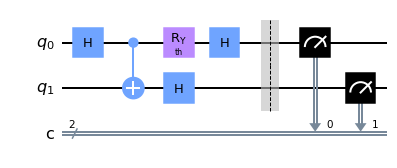

In [2]:
chsh_circuits[3].draw()

## Parameterized circuits: Sampler and Estimator


As described above, we will evaluate the circuits over different phases for the first qubit's measurement base:

In [4]:
import numpy as np

number_of_phases = 50
phases = np.linspace(0, 2*np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

## Step 2: Submit the circuits to a quantum computer on the cloud



### Connect to the Qiskit Runtime service  

First, you will connect to the Qiskit Runtime service instance that you created in [the first step](#before-you-begin). We will use `ibmq_qasm_simulator` to run this tutorial.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
options = {'backend_name': 'ibmq_qasm_simulator'}  # use the simulator

### Sampler

Here we call the `Sampler` in the form of a Python Context Manager:

In [6]:
from qiskit_ibm_runtime import Sampler

chsh_results_sim = []
chsh_results_exp = []
for chsh_circ in chsh_circuits:
    qc = chsh_circ
    # Simulator
    with Sampler(circuits=[qc], service=service, options=options) as sampler:
        param_results = sampler(circuits=[0]*len(phases), parameter_values=individual_phases)
        chsh_results_sim.append(param_results)

    # Real device
    with Sampler(circuits=[qc], service=service, options=options) as sampler:
        param_results = sampler(circuits=[0]*len(phases), parameter_values=individual_phases)
        chsh_results_exp.append(param_results)

/var/folders/3q/wv2nrp5s3d9c4ftzs7zdfrx40000gn/T/ipykernel_43303/3618758552.py:9: DeprecationWarning: __call__ keyword argument circuit_indices is deprecated and replaced with circuits.
  param_results = sampler(circuit_indices=[0]*len(phases), parameter_values=individual_phases)
/var/folders/3q/wv2nrp5s3d9c4ftzs7zdfrx40000gn/T/ipykernel_43303/3618758552.py:14: DeprecationWarning: __call__ keyword argument circuit_indices is deprecated and replaced with circuits.
  param_results = sampler(circuit_indices=[0]*len(phases), parameter_values=individual_phases)


After running the circuits, we need to build the CHSH witness functions. We first build the quantities $\langle AB \rangle$, $\langle Ab \rangle$, $\langle aB \rangle$, and $\langle ab \rangle$, by looking at the parity of the outcomes for the four families of circuits we built (two measurement bases for each of the two qubits). Then we use those quantities to build the witness functions as defined above.

In [7]:
chsh_sim = []
chsh_exp = []

for chsh_result_sim in chsh_results_sim:
    
    obs_0 = [dist.get('00', 0) for dist in chsh_result_sim.quasi_dists]
    obs_1 = [dist.get('01', 0) for dist in chsh_result_sim.quasi_dists]
    obs_2 = [dist.get('10', 0) for dist in chsh_result_sim.quasi_dists]
    obs_3 = [dist.get('11', 0) for dist in chsh_result_sim.quasi_dists]
    
    chsh_sim.append([i-j-k+l for i,j,k,l in zip(obs_0,obs_1,obs_2,obs_3)])
    
for chsh_result_exp in chsh_results_exp:
    
    obs_0 = [dist.get('00', 0) for dist in chsh_result_exp.quasi_dists]
    obs_1 = [dist.get('01', 0) for dist in chsh_result_exp.quasi_dists]
    obs_2 = [dist.get('10', 0) for dist in chsh_result_exp.quasi_dists]
    obs_3 = [dist.get('11', 0) for dist in chsh_result_exp.quasi_dists]
    
    chsh_exp.append([i-j-k+l for i,j,k,l in zip(obs_0,obs_1,obs_2,obs_3)])
    
AB_sim = chsh_sim[0]
Ab_sim = chsh_sim[1]
aB_sim = chsh_sim[2]
ab_sim = chsh_sim[3]

AB_exp = chsh_exp[0]
Ab_exp = chsh_exp[1]
aB_exp = chsh_exp[2]
ab_exp = chsh_exp[3]
   
chsh1_sim = [i-j+k+l for i,j,k,l in zip(AB_sim,Ab_sim,aB_sim,ab_sim)]
chsh2_sim = [i+j-k+l for i,j,k,l in zip(AB_sim,Ab_sim,aB_sim,ab_sim)]

chsh1_exp = [i-j+k+l for i,j,k,l in zip(AB_exp,Ab_exp,aB_exp,ab_exp)]
chsh2_exp = [i+j-k+l for i,j,k,l in zip(AB_exp,Ab_exp,aB_exp,ab_exp)]

Now let's plot the results. First, we define some figure properties:

In [8]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          'figure.figsize': (10, 6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

Then make the plot:

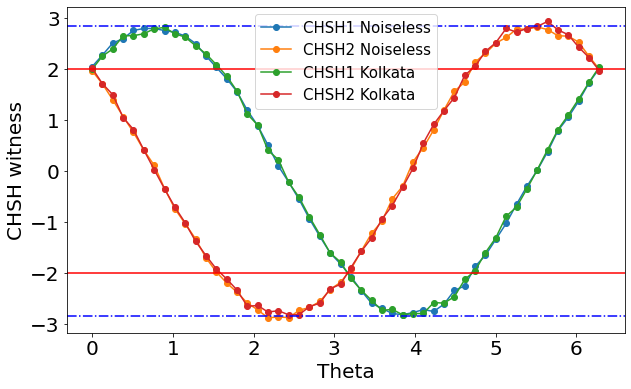

In [10]:
import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(10, 6))

# ax1 = fig.add_axes([0, 0, 1, 1])

plt.plot(phases, chsh1_sim, 'o-', label='CHSH1 Noiseless')
plt.plot(phases, chsh2_sim, 'o-', label='CHSH2 Noiseless')
plt.plot(phases, chsh1_exp, 'o-', label='CHSH1 Kolkata')
plt.plot(phases, chsh2_exp, 'o-', label='CHSH2 Kolkata')
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='b', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='b', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.legend()

In the figure above, the red lines delimit the classical bound and the dash-dotted blue lines delimit the quantum bound. We indeed observe a violation of the $CHSH$ inequality in our real device!

### Estimator

The `Estimator` primitive can enormously simplify circuit building and output analysis by directly providing expectation values of observables. Many problems of interest, especially for near-term applications on noisy systems, can be formulated in terms of expectation values. For maximum generalization, the `Estimator` primitive requires circuits with no measurements:

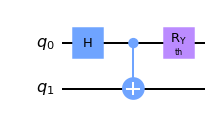

In [11]:
chsh_circuits_no_meas = QuantumCircuit(2)
chsh_circuits_no_meas.h(0)
chsh_circuits_no_meas.cx(0, 1)
chsh_circuits_no_meas.ry(th, 0)
chsh_circuits_no_meas.draw('mpl')

Now we need observables from which to compute the expectation values.  In our case we are looking at orthogonal bases for each qubit, letting the parameterized $Y-$rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis. We will therefore choose the observables $ZZ$, $ZX$, $XZ$, and $XX$.

**Important** - This currently works for Pauli operators only.  Also, because there are no measurements from which to infer the number of qubits in the observable, one must pad the observable with identity (`I`) operators. 

In [16]:
from qiskit_ibm_runtime import Estimator

ops = ['ZZ','ZX','XZ','XX'] # Zeroth qubit is farthest to the right
chsh_est_sim = []
chsh_est_exp = []

for op in ops:
    # Simulator
    with Estimator(circuits=[chsh_circuits_no_meas], observables=[op],
                   service=service, options=options) as estimator:
        est_result = estimator(circuits=[0]*len(phases),
                           observables=[0]*len(phases),
                           parameter_values=individual_phases)
        chsh_est_sim.append(est_result)
        
    # Real device
    with Estimator(circuits=[chsh_circuits_no_meas], observables=[op],
                   service=service, options=options) as estimator:
        est_result = estimator(circuits=[0]*len(phases),
                           observables=[0]*len(phases),
                           parameter_values=individual_phases)
        chsh_est_exp.append(est_result)
        
chsh1_est_sim = chsh_est_sim[0].values - chsh_est_sim[1].values + chsh_est_sim[2].values + chsh_est_sim[3].values
chsh2_est_sim = chsh_est_sim[0].values + chsh_est_sim[1].values - chsh_est_sim[2].values + chsh_est_sim[3].values

chsh1_est_exp = chsh_est_exp[0].values - chsh_est_exp[1].values + chsh_est_exp[2].values + chsh_est_exp[3].values
chsh2_est_exp = chsh_est_exp[0].values + chsh_est_exp[1].values - chsh_est_exp[2].values + chsh_est_exp[3].values

AttributeError: 'str' object has no attribute 'num_qubits'

Note that now we do not have to build the observables ourselves because they are returned to us! The computed expectation values are given in `result.values`. What comes back is a very small payload of data.

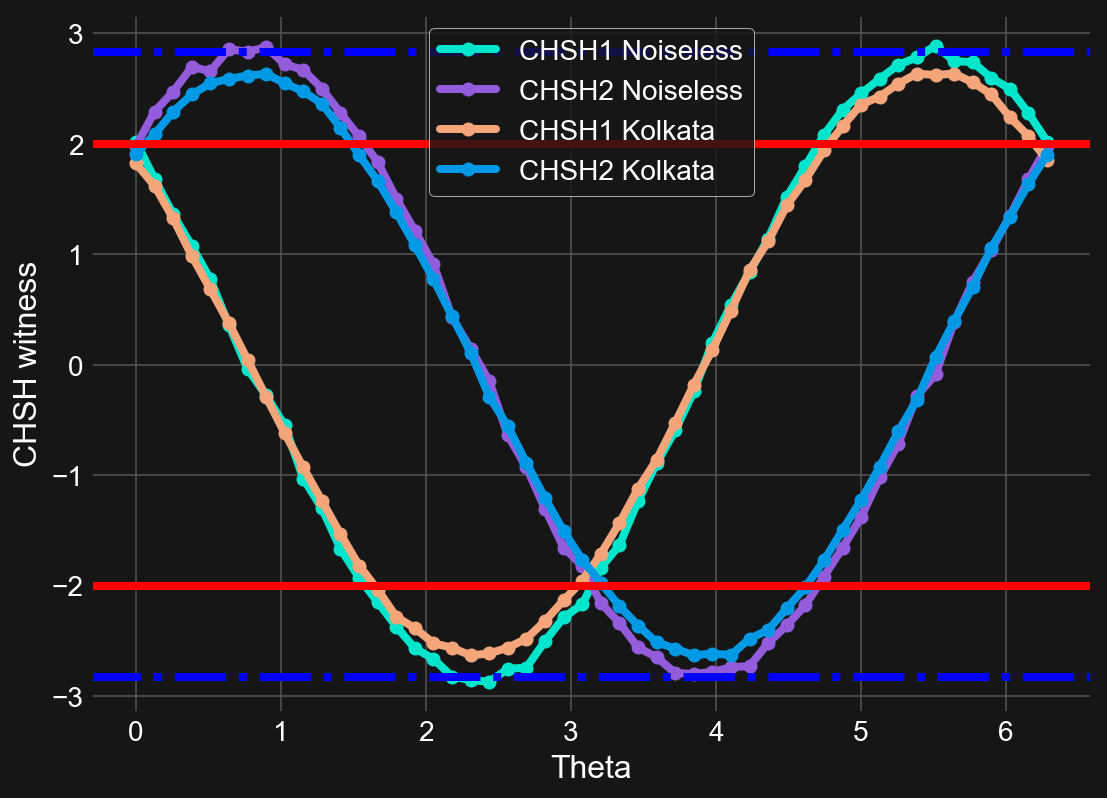

In [200]:
plt.plot(phases, chsh1_est_sim, 'o-', label='CHSH1 Noiseless')
plt.plot(phases, chsh2_est_sim, 'o-', label='CHSH2 Noiseless')
plt.plot(phases, chsh1_est_exp, 'o-', label='CHSH1 Kolkata')
plt.plot(phases, chsh2_est_exp, 'o-', label='CHSH2 Kolkata')
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='b', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='b', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.legend()